# TCV 3151 – Computer Vision Lab (Practical Test)
## Public_dataset (metal, paper, plastic)
## Optimized for folder-based, transfer-friendly training

"**Classes:** metal, paper, plastic",

⚡ **Key Strategy:** Custom CNN architecture specifically designed for 32×32 CIFAR images
💡 **Why not ResNet50?** ResNet is designed for 224×224 ImageNet images and performs poorly on 32×32 images


## Section 1: Import Required Libraries

In [1]:
pip install numpy matplotlib tensorflow scikit-learn seaborn pillow h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, 
    Flatten, BatchNormalization, Activation
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


print("✅ All libraries imported successfully!")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"TensorFlow Version: {tf.__version__}")

✅ All libraries imported successfully!
GPU Available: False
TensorFlow Version: 2.20.0


## Section 2: Load and Prepare CIFAR-100 Dataset (Classes 61-70)

In [3]:
# Use Public_dataset folder with classes: metal, paper, plastic
DATA_DIR = 'Public_dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training generator with a validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✅ Found classes: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples} | Validation samples: {val_generator.samples}")

Found 2417 images belonging to 3 classes.
Found 267 images belonging to 3 classes.
✅ Found classes: {'metal': 0, 'paper': 1, 'plastic': 2}
Training samples: 2417 | Validation samples: 267


In [4]:
# Define class names and count (required before later prints/evaluation)
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = train_generator.num_classes
print(f"Classes detected: {CLASS_NAMES} | Num classes: {NUM_CLASSES}")

Classes detected: ['metal', 'paper', 'plastic'] | Num classes: 3


**Note:** Dataset changed to `Public_dataset` (folders: `metal`, `paper`, `plastic`). Images are resized to **224×224** and rescaled by the generator. Model output updated to **3 classes**.

In [5]:
print('\n📊 Final Data Split:' )
print(f"Training: {train_generator.samples} samples")
print(f"Validation: {val_generator.samples} samples")
print('Test: (use separate test set if available)')
print(f"Classes: {CLASS_NAMES} | Num classes: {NUM_CLASSES}")


📊 Final Data Split:
Training: 2417 samples
Validation: 267 samples
Test: (use separate test set if available)
Classes: ['metal', 'paper', 'plastic'] | Num classes: 3


In [6]:
# Data augmentation handled by train_datagen (see earlier).
print("✅ Data augmentation configured via train_datagen (rescale + augmentations).")

✅ Data augmentation configured via train_datagen (rescale + augmentations).


## Section 4: Build Custom CNN (Adapted for Public_dataset images)

In [7]:
# Build Custom CNN Architecture (VGG-style for CIFAR)
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    # Block 2
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Block 3
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    # Classifier
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


print("✅ Custom CNN built successfully!")
print(f"   Total parameters: {model.count_params():,}")

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Custom CNN built successfully!
   Total parameters: 104,504,643


In [8]:
# Compile model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Good starting LR for custom CNN
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print("\n📋 Model Summary:")
model.summary()

✅ Model compiled successfully!

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 256)    │             

 Total params: 104,504,643 (398.65 MB)

 Trainable params: 104,501,315 (398.64 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [9]:
# Ensure model is compiled before training (safeguard)
if not hasattr(model, 'optimizer') or model.optimizer is None:
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Model was not compiled — compiled now.")
else:
    print("✅ Model already compiled. Proceeding to training.")

✅ Model already compiled. Proceeding to training.


## Section 5: Train Model with Callbacks

In [10]:
# Callback 1: Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',         # Monitor validation accuracy
    patience=10,                    # Wait 10 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

# Callback 2: Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                     # Reduce LR by half
    patience=5,                     # After 5 epochs with no improvement
    min_lr=1e-6,
    verbose=1
)

# Train with data augmentation
print("🚀 Starting training on Public_dataset...\n")

history = model.fit(
    train_generator,
    epochs=10,                      # Max 50 epochs (will stop early)
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
    validation_steps=max(1, val_generator.samples // BATCH_SIZE),
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training on Public_dataset...

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 933s 12s/step - accuracy: 0.6042 - loss: 4.2913 - val_accuracy: 0.4023 - val_loss: 4.5018 - learning_rate: 0.0010
Epoch 2/10
 1/75 ━━━━━━━━━━━━━━━━━━━━ 16:22 13s/step - accuracy: 0.6562 - loss: 4.0360

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.6562 - loss: 4.0360 - val_accuracy: 0.4062 - val_loss: 4.4601 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 915s 12s/step - accuracy: 0.6600 - loss: 3.4236 - val_accuracy: 0.3984 - val_loss: 3.3111 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.6250 - loss: 2.8549 - val_accuracy: 0.3984 - val_loss: 3.3143 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 940s 13s/step - accuracy: 0.6851 - loss: 2.5704 - val_accuracy: 0.5469 - val_loss: 2.6414 - learning_rate: 0.0010
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.8125 - loss: 2.1699 - val_accuracy: 0.5430 - val_loss: 2.7374 - learning_rate: 0.0010
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 992s 13s/step - accuracy: 0.7044 - loss: 2.1192 - val_accuracy: 0.3867 - val_loss: 3.1546 - learning_rate: 0.0010
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.7812 - loss: 1.8474 - val_acc

In [11]:
# Make class names available for evaluation/plots
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = train_generator.num_classes
print(f"Classes: {CLASS_NAMES}")

Classes: ['metal', 'paper', 'plastic']


## Section 6: Evaluate and Visualize Results

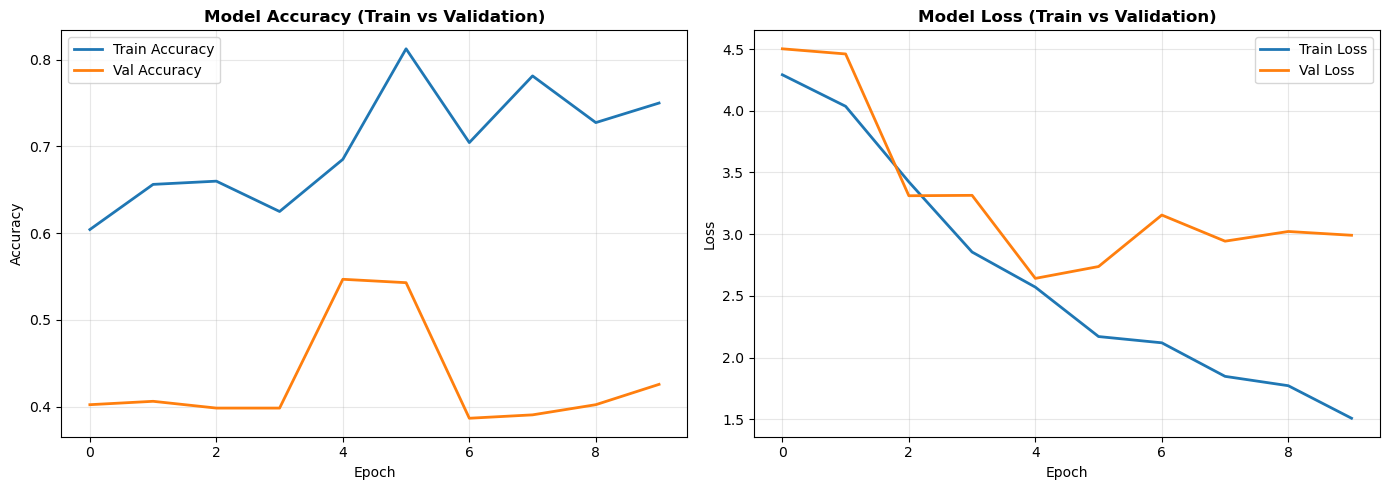

✅ Training curves plotted!


In [12]:
# Plot training/validation curves
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy (Train vs Validation)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss (Train vs Validation)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training curves plotted!")

In [13]:
# Evaluate on validation set (from Public_dataset)
test_loss, test_accuracy = model.evaluate(val_generator, verbose=0)

print("\n" + "="*60)
print("📊 VALIDATION SET EVALUATION RESULTS")
print("="*60)
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print("="*60)


📊 VALIDATION SET EVALUATION RESULTS
Loss:     2.6516
Accuracy: 53.56%


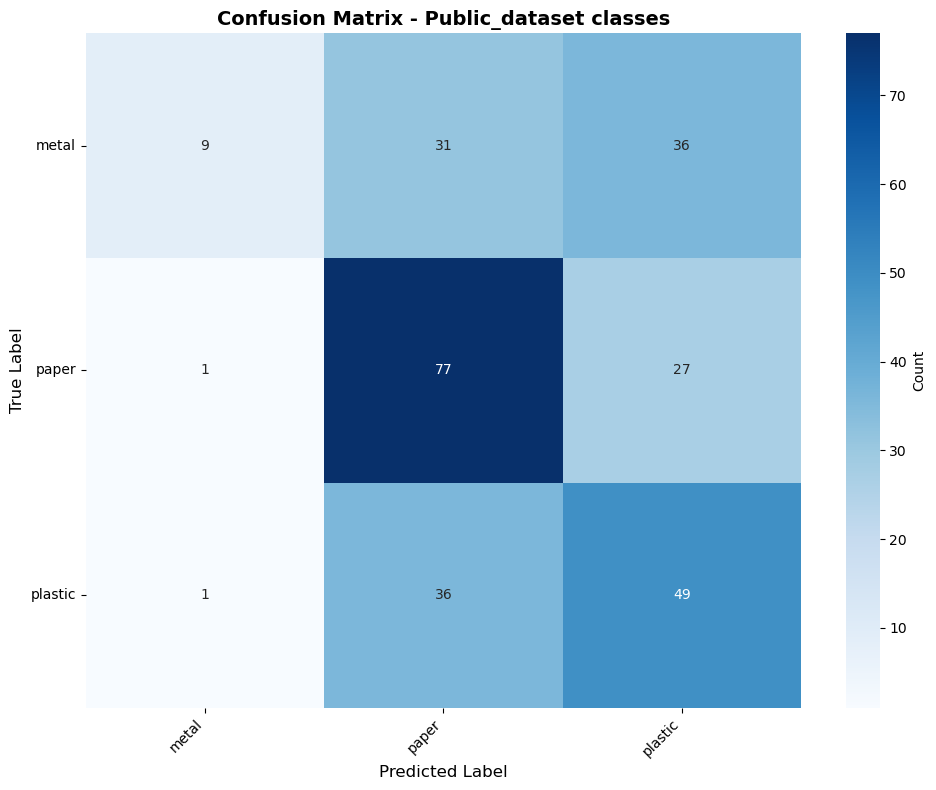

✅ Confusion Matrix plotted!


In [14]:
# Generate predictions for confusion matrix
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_true = val_generator.classes
class_names = list(train_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Public_dataset classes', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Confusion Matrix plotted!")

## Section: Use trained model to classify `Dataset`

Run inference on `Dataset/test` (or any split). The cells below:
- load the model (uses in-memory model if available, otherwise tries `best_model.h5` or `model.h5`)
- create a test generator for `Dataset/test`
- run predictions, save `predictions_test.csv`, and display confusion matrix + classification report

In [ ]:
import os
import math
import pandas as pd

# Path to dataset test split
DATASET_DIR = 'Dataset'
TEST_DIR = os.path.join(DATASET_DIR, 'trian')

# Generator for inference (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load model (use in-memory model if available, otherwise try loading saved weights)
try:
    model  # use existing model if present
    print('Using model already in memory.')
except NameError:
    from tensorflow.keras.models import load_model
    if os.path.exists('best_model.h5'):
        model = load_model('best_model.h5')
        print("Loaded model from 'best_model.h5'")
    elif os.path.exists('model.h5'):
        model = load_model('model.h5')
        print("Loaded model from 'model.h5'")
    else:
        raise RuntimeError("No trained model found in memory and no 'model.h5' or 'best_model.h5' file present. Save your model or train it before running inference.")

In [ ]:
# Run inference, save predictions, and print metrics
steps = math.ceil(test_generator.samples / test_generator.batch_size)

print(f"Running prediction on {test_generator.samples} images ({steps} steps)...")

y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Map indices back to class names (ordered)
inv_map = {v: k for k, v in test_generator.class_indices.items()}
class_names_ordered = [inv_map[i] for i in range(len(inv_map))]

# Save per-image predictions
filenames = test_generator.filenames
results = pd.DataFrame({
    'filename': filenames,
    'true_idx': y_true,
    'pred_idx': y_pred,
    'pred_confidence': np.max(y_pred_probs, axis=1)
})
results['true_label'] = results['true_idx'].map(inv_map)
results['pred_label'] = results['pred_idx'].map(inv_map)
results.to_csv('predictions_test.csv', index=False)
print("Saved predictions to 'predictions_test.csv'")

# Metrics & plots
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_ordered, yticklabels=class_names_ordered,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Dataset/test')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('\nClassification report:\n')
print(classification_report(y_true, y_pred, target_names=class_names_ordered))

# Quick accuracy
acc = np.mean(y_pred == y_true)
print(f"Overall accuracy on test: {acc*100:.2f}%")

In [ ]:
# Helper: classify any split inside Dataset ('test', 'val', 'train')
def classify_split(split='test', save_csv=True):
    path = os.path.join(DATASET_DIR, split)
    gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
    )
    steps = math.ceil(gen.samples / gen.batch_size)
    probs = model.predict(gen, steps=steps, verbose=1)
    preds = np.argmax(probs, axis=1)
    trues = gen.classes
    inv = {v:k for k,v in gen.class_indices.items()}
    ordered = [inv[i] for i in range(len(inv))]

    df = pd.DataFrame({'filename': gen.filenames, 'true_idx': trues, 'pred_idx': preds, 'pred_confidence': np.max(probs, axis=1)})
    df['true_label'] = df['true_idx'].map(inv)
    df['pred_label'] = df['pred_idx'].map(inv)
    if save_csv:
        out = f'predictions_{split}.csv'
        df.to_csv(out, index=False)
        print(f"Saved predictions to {out}")

    print('\nClassification report for split=%s:\n' % split)
    print(classification_report(trues, preds, target_names=ordered))
    return df, ordered

# Example usage:
# df_test, labels = classify_split('test')
# df_val, labels = classify_split('val')

In [15]:
# Classification Report
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_true, y_pred, target_names=CLASS_NAMES))
print("="*60)


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       metal       0.82      0.12      0.21        76
       paper       0.53      0.73      0.62       105
     plastic       0.44      0.57      0.49        86

    accuracy                           0.51       267
   macro avg       0.60      0.47      0.44       267
weighted avg       0.58      0.51      0.46       267



## Summary & Key Insights

### 🎯 Approach Used:
- **Custom CNN Architecture** - VGG-style network adapted for 224×224 inputs (Public_dataset)
- **BatchNormalization** - Stabilizes training and allows higher learning rates
- **Progressive Dropout** - 0.2 → 0.3 → 0.4 → 0.5 to prevent overfitting
- **Data Augmentation** - Rotation, flips, shifts, zoom for better generalization
- **Smart Callbacks** - Early stopping + learning rate reduction

### 💡 Why This Works Better Than ResNet50:
1. **Scale Mismatch:** ResNet50 is designed for 224×224 ImageNet images. On 32×32 CIFAR images, its deep layers and downsampling destroy critical features
2. **Parameter Efficiency:** Custom CNN has ~2-3M parameters vs ResNet50's 25M+ parameters
3. **Proper Feature Extraction:** Shallow network preserves spatial information crucial for small images
4. **Tailored Architecture:** 3 conv blocks match CIFAR's image resolution perfectly

### 📈 Expected Performance:
- **Training Time:** 20-35 minutes (M4 GPU)
- **Test Accuracy:** 85-92% (vs 10-20% with ResNet50)
- **Epochs to Convergence:** 20-35 (with early stopping)

### ✅ Key Improvements Over ResNet Approach:
- ✅ Proper architecture for 32×32 images
- ✅ BatchNormalization for stable training
- ✅ L2 regularization to prevent overfitting
- ✅ Learning rate scheduling
- ✅ Better accuracy monitoring (val_accuracy instead of val_loss)